# Multilayer Perception (MLP)

Group Member: WuZhanxin

In this section, we implement two MLP for real-world image classification and sketch images classification. Using these two models, we compute similarites between features and return the top k real-world images with high similarities for each sketcj.


You can (1) run the training part in the following codes to train new MLP or (2) directly load my pretrained model.
We also provide Search Engine Accuracy Check and Model History Plot here.

Enjoy the codes~

## Import Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from torchvision import transforms
import torch
import random

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


## Load our Dataset Structure

In [2]:
## Load Train and Validation Data
class ImageDataset(Dataset):
    """ Own dataset """

    def __init__(self, img_dir, fruit_category, image_size = 255, class_size = 5000):
        """
        Args:
            sketch_dir (string): Directory to all the sketch images.
            realworld_dir (string): Directory to all the real world images.
            fruit_category: list to fruit catogory
            class_size: Num of images in each category
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.fruit_category = fruit_category
        self.class_size = class_size
        self.data_dict = dict(np.load(img_dir))
        self.image_size = image_size
        
        self.transform_img = transforms.Compose([transforms.ToPILImage(),
                                                transforms.Resize(image_size),
                                                transforms.ToTensor()])
        self.transform_label = transforms.Compose([transforms.ToTensor()])
        
    def __len__(self):
        return self.class_size * len(self.fruit_category)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        class_index = int(idx // self.class_size)
        category =  self.fruit_category[class_index]
        category_idx = int(idx % self.class_size)
        
        label = np.zeros((len(self.fruit_category), 1))
        label[class_index] = 1

#         print(class_index)
#         label = class_index
        
        image_ary =  self.data_dict[category][category_idx]
        
        sample = {'image': image_ary, 'label': label}
        if self.transform:
            sample['image'] = self.transform_img(sample['image'])
            sample['label'] = self.transform_label(sample['label'])
        return sample
  

## Load Train and Validation Data

In [3]:
QURIES = ['pineapple', 'apple', 'banana', 'strawberry', 'pear', 'watermelon', 'grapes']  
train_quickdraw_dir = './data/compressed_quickdraw_train.npz'
test_quickdraw_dir = './data/compressed_quickdraw_test.npz'
train_quickdraw = ImageDataset(train_quickdraw_dir, QURIES, image_size = 32, class_size = 4000)
test_quickdraw = ImageDataset(test_quickdraw_dir, QURIES, image_size = 32, class_size = 1000)

train_realworld_dir = './data/compressed_realworld_train.npz'
test_realworld_dir = './data/compressed_realworld_test.npz'
train_realworld = ImageDataset(train_realworld_dir, QURIES, image_size = 32, class_size = 4000)
test_realworld= ImageDataset(test_realworld_dir, QURIES, image_size = 32, class_size = 1000)

In [4]:
quickdraw_trainloader = DataLoader(train_quickdraw, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)
quickdraw_testloader = DataLoader(test_quickdraw, batch_size=10, shuffle=True, pin_memory=True, num_workers=32)

realworld_trainloader = DataLoader(train_realworld, batch_size=128, shuffle=True, pin_memory=True, num_workers=32)
realworld_testloader = DataLoader(test_realworld, batch_size=10, shuffle=True, pin_memory=True, num_workers=32)


## MLP Model Structure

Notice: we use two MLPs for real-world images classification and sketch images classification.

In [5]:
class MLP(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(x_dim, 1024, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(1024, 512, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(512, 256, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(256, 128, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(128, y_dim, bias=False)
        )
        
    def forward(self, x):
        x = self.mlp(x.flatten(1))
        return x 


In [6]:
# model = MLP(255*255*3,7).to(device)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
realworld_model = MLP(32*32*3,7).to(device)
quickdraw_model = MLP(32*32*3,7).to(device)
print(f'realworld_model: {realworld_model}')
print(f'quickdraw_model: {quickdraw_model}')

realworld_model: MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=False)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): Linear(in_features=256, out_features=128, bias=False)
    (7): LeakyReLU(negative_slope=0.3, inplace=True)
    (8): Linear(in_features=128, out_features=7, bias=False)
  )
)
quickdraw_model: MLP(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=False)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): Linear(in_features=2

## Define Training Parameters

In [9]:
quickdraw_epochs = 50
quickdraw_loss_fn = nn.CrossEntropyLoss()
quickdraw_optimizer = torch.optim.AdamW(quickdraw_model.parameters(), lr=1e-4, weight_decay=5e-4)
quickdraw_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(quickdraw_optimizer, T_max=quickdraw_epochs)

In [10]:
realworld_epochs = 50
realworld_loss_fn = nn.CrossEntropyLoss()
realworld_optimizer = torch.optim.AdamW(realworld_model.parameters(), lr=1e-4, weight_decay=5e-4)
realworld_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(realworld_optimizer, T_max=realworld_epochs)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for _, data in enumerate(dataloader):
        X, y = data['image'].to(device), data['label'].to(device)
        y = y.squeeze()
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (_ % 100 == 0):
            loss, current = loss.item(), _ * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    correct /= size
    return correct, train_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
         for _, data in enumerate(dataloader):
            X, y = data['image'].to(device), data['label'].to(device)
            y = y.squeeze()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print("------------ Test -----------")
    print(f"Accuracy: {(100*correct):>2f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss


## Train and Test Procedure

### Notice: If you want to load our pretrained model, please skip this section.

In [117]:
realworld_train_accuracy = []
realworld_train_loss = []
realworld_test_accuracy = []
realworld_test_loss = []

for t in range(realworld_epochs):
    print(f"---------- Epoch {t+1} ----------")
    train_acc, train_loss = train(realworld_trainloader, realworld_model, realworld_loss_fn, realworld_optimizer)
    test_acc, test_loss = test(realworld_testloader, realworld_model, realworld_loss_fn)
    realworld_scheduler.step()
    realworld_train_loss.append(train_loss)
    realworld_train_accuracy.append(train_acc)
    realworld_test_accuracy.append(test_acc)
    realworld_test_loss.append(test_loss)


---------- Epoch 1 ----------
Loss: 1.947602  [    0/28000]
Loss: 1.530133  [12800/28000]
Loss: 1.541171  [25600/28000]
------------ Test -----------
Accuracy: 47.442857%, Avg loss: 1.333763 

---------- Epoch 2 ----------
Loss: 1.460051  [    0/28000]
Loss: 1.204281  [12800/28000]
Loss: 1.196569  [25600/28000]
------------ Test -----------
Accuracy: 54.185714%, Avg loss: 1.174042 

---------- Epoch 3 ----------
Loss: 1.179531  [    0/28000]
Loss: 1.133294  [12800/28000]
Loss: 1.085713  [25600/28000]
------------ Test -----------
Accuracy: 58.914286%, Avg loss: 1.094627 

---------- Epoch 4 ----------
Loss: 1.161478  [    0/28000]
Loss: 0.918892  [12800/28000]
Loss: 0.940817  [25600/28000]
------------ Test -----------
Accuracy: 64.771429%, Avg loss: 0.940366 

---------- Epoch 5 ----------
Loss: 1.008688  [    0/28000]
Loss: 1.231172  [12800/28000]
Loss: 1.094392  [25600/28000]
------------ Test -----------
Accuracy: 68.371429%, Avg loss: 0.897555 

---------- Epoch 6 ----------
Loss:

Loss: 0.417123  [12800/28000]
Loss: 0.368544  [25600/28000]
------------ Test -----------
Accuracy: 84.485714%, Avg loss: 0.502493 

---------- Epoch 44 ----------
Loss: 0.376948  [    0/28000]
Loss: 0.442478  [12800/28000]
Loss: 0.400259  [25600/28000]
------------ Test -----------
Accuracy: 84.600000%, Avg loss: 0.498833 

---------- Epoch 45 ----------
Loss: 0.417142  [    0/28000]
Loss: 0.396793  [12800/28000]
Loss: 0.379433  [25600/28000]
------------ Test -----------
Accuracy: 84.957143%, Avg loss: 0.488297 

---------- Epoch 46 ----------
Loss: 0.420357  [    0/28000]
Loss: 0.402711  [12800/28000]
Loss: 0.364849  [25600/28000]
------------ Test -----------
Accuracy: 84.857143%, Avg loss: 0.496459 

---------- Epoch 47 ----------
Loss: 0.498178  [    0/28000]
Loss: 0.446654  [12800/28000]
Loss: 0.512261  [25600/28000]
------------ Test -----------
Accuracy: 84.600000%, Avg loss: 0.500174 

---------- Epoch 48 ----------
Loss: 0.314906  [    0/28000]
Loss: 0.453095  [12800/28000]


In [119]:
quickdraw_train_accuracy = []
quickdraw_train_loss = []
quickdraw_test_accuracy = []
quickdraw_test_loss = []

for t in range(realworld_epochs):
    print(f"---------- Epoch {t+1} ----------")
    train_acc, train_loss = train(quickdraw_trainloader, quickdraw_model, quickdraw_loss_fn, quickdraw_optimizer)
    test_acc, test_loss = test(quickdraw_testloader,quickdraw_model, quickdraw_loss_fn)
    quickdraw_scheduler.step()
    quickdraw_train_loss.append(train_loss)
    quickdraw_train_accuracy.append(train_acc)
    quickdraw_test_accuracy.append(test_acc)
    quickdraw_test_loss.append(test_loss)

---------- Epoch 1 ----------
Loss: 1.946431  [    0/28000]
Loss: 1.947912  [12800/28000]
Loss: 1.930878  [25600/28000]
------------ Test -----------
Accuracy: 14.285714%, Avg loss: 1.942384 

---------- Epoch 2 ----------
Loss: 1.940372  [    0/28000]
Loss: 1.615267  [12800/28000]
Loss: 1.631989  [25600/28000]
------------ Test -----------
Accuracy: 43.657143%, Avg loss: 1.421234 

---------- Epoch 3 ----------
Loss: 1.435910  [    0/28000]
Loss: 1.392373  [12800/28000]
Loss: 1.212800  [25600/28000]
------------ Test -----------
Accuracy: 55.471429%, Avg loss: 1.261795 

---------- Epoch 4 ----------
Loss: 1.199508  [    0/28000]
Loss: 1.162721  [12800/28000]
Loss: 1.152749  [25600/28000]
------------ Test -----------
Accuracy: 63.485714%, Avg loss: 1.124089 

---------- Epoch 5 ----------
Loss: 1.126133  [    0/28000]
Loss: 1.225582  [12800/28000]
Loss: 0.895389  [25600/28000]
------------ Test -----------
Accuracy: 64.471429%, Avg loss: 1.064236 

---------- Epoch 6 ----------
Loss:

Loss: 0.835484  [12800/28000]
Loss: 0.686220  [25600/28000]
------------ Test -----------
Accuracy: 76.300000%, Avg loss: 0.723546 

---------- Epoch 44 ----------
Loss: 0.674256  [    0/28000]
Loss: 0.917389  [12800/28000]
Loss: 0.889046  [25600/28000]
------------ Test -----------
Accuracy: 77.000000%, Avg loss: 0.709864 

---------- Epoch 45 ----------
Loss: 0.645715  [    0/28000]
Loss: 0.710177  [12800/28000]
Loss: 0.912723  [25600/28000]
------------ Test -----------
Accuracy: 76.685714%, Avg loss: 0.708786 

---------- Epoch 46 ----------
Loss: 0.733036  [    0/28000]
Loss: 0.786170  [12800/28000]
Loss: 0.643306  [25600/28000]
------------ Test -----------
Accuracy: 77.000000%, Avg loss: 0.707587 

---------- Epoch 47 ----------
Loss: 0.764996  [    0/28000]
Loss: 0.666769  [12800/28000]
Loss: 0.591614  [25600/28000]
------------ Test -----------
Accuracy: 77.085714%, Avg loss: 0.708262 

---------- Epoch 48 ----------
Loss: 0.707878  [    0/28000]
Loss: 0.794553  [12800/28000]


In [127]:
torch.save(realworld_model.state_dict(), './model/realworld_mlp.pth')
torch.save(quickdraw_model.state_dict(), './model/quickdraw_mlp.pth')

## Load our Pretrained Model

In [12]:
## Load our Pretrained Model
realworld_model = MLP(32*32*3,7).to(device)
realworld_model.load_state_dict(torch.load('./model/realworld_mlp.pth'))

quickdraw_model = MLP(32*32*3,7).to(device)
quickdraw_model.load_state_dict(torch.load('./model/quickdraw_mlp.pth'))

<All keys matched successfully>

## Test Search Engine Accuracy

The test_k includes all the k value we want to test, where k means the number of real-world images we will return for each sketch.

In [14]:
## Test Search Engine Accuracy
retrieve_realworld_loader = DataLoader(test_realworld, batch_size=1000, shuffle=True, pin_memory=True, num_workers=32)
realworld_model.eval()
with torch.no_grad():
    for _, data in enumerate(retrieve_realworld_loader):
        realworld_X, y = data['image'].to(device), data['label'].to(device)
        realworld_y = y.squeeze()
        realworld_pred = realworld_model(realworld_X)
print('Finish Creating Real World Image Feature!')

retrieve_quickdraw_loader = DataLoader(test_quickdraw, batch_size=1, shuffle= True, pin_memory=True, num_workers=32)

def search_engine_evaluation(retrieve_quickdraw_loader, realworld_pred, k = 3):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    count_accuracy = 0
    quickdraw_model.eval()
    with torch.no_grad():
         for _, data in enumerate(retrieve_quickdraw_loader):
            quickdraw_X, y = data['image'].to(device), data['label'].to(device)
            quickdraw_y = y.squeeze()
            quickdraw_pred = quickdraw_model(quickdraw_X)  
            realworld_pred = nn.functional.normalize(realworld_pred)
            quickdraw_pred = nn.functional.normalize(quickdraw_pred)
            cos_similarity = cos(realworld_pred,quickdraw_pred)
            topk_index = torch.topk(cos_similarity, k).indices
            count_accuracy += (realworld_y[topk_index].argmax(1) == quickdraw_y.argmax()).sum()
    final_acc = (count_accuracy/(len(retrieve_quickdraw_loader) * k ) )
    print(f'Find Top {k} Realworld Images Retreive Accuracy: {(100*final_acc):>2f}%')
    return final_acc

test_k = [1,3,5,10,20]
topk_acc = []
for k in test_k:
    k_acc = search_engine_evaluation(retrieve_quickdraw_loader, realworld_pred, k)
    topk_acc.append(k_acc.item())

Finish Creating Real World Image Feature!
Find Top 1 Realworld Images Retreive Accuracy: 58.742859%
Find Top 3 Realworld Images Retreive Accuracy: 63.152378%
Find Top 5 Realworld Images Retreive Accuracy: 64.111427%
Find Top 10 Realworld Images Retreive Accuracy: 64.470001%
Find Top 20 Realworld Images Retreive Accuracy: 64.035713%


In [129]:
import pickle

model_history = {
    "epoch": range(len(realworld_train_accuracy)),
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],

    # Please save the following metric
    "train_realworld_acc": realworld_train_accuracy,
    "train_quickdraw_acc": quickdraw_train_accuracy,
    "val_realworld_acc": realworld_test_accuracy,
    "val_quickdraw_acc": quickdraw_test_accuracy,
    "train_realworld_loss": realworld_train_loss,
    "train_quickdraw_loss": quickdraw_train_loss,
    "val_realworld_loss": realworld_test_loss,
    "val_quickdraw_loss": quickdraw_test_loss,
    "k_choice": test_k, # [1,3,5,10,20]
    "topk_acc": topk_acc
}


def save_model_history(metrics, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(metrics, file)

def load_model_history(filepath):
    with open(filepath, 'rb') as file:
        metrics = pickle.load(file)
    return metrics

save_model_history(model_history, './model/MLP.pkl')


In [130]:
model_history = load_model_history('./model/MLP.pkl')
model_history

{'epoch': range(0, 50),
 'train_loss': [],
 'train_acc': [],
 'test_loss': [],
 'test_acc': [],
 'train_realworld_acc': [0.38489285714285715,
  0.4817142857142857,
  0.5411428571428571,
  0.5786428571428571,
  0.6065357142857143,
  0.6264642857142857,
  0.6454642857142857,
  0.6618928571428572,
  0.6681785714285714,
  0.68225,
  0.69075,
  0.7024285714285714,
  0.7141428571428572,
  0.7164642857142857,
  0.7335357142857143,
  0.7366785714285714,
  0.7447857142857143,
  0.7544285714285714,
  0.761,
  0.7678928571428572,
  0.7713214285714286,
  0.7829642857142857,
  0.7835,
  0.7913571428571429,
  0.7929642857142857,
  0.8006071428571429,
  0.8073928571428571,
  0.814,
  0.8159285714285714,
  0.8261071428571428,
  0.83025,
  0.8353928571428572,
  0.8393571428571428,
  0.8444642857142857,
  0.8485357142857143,
  0.8508571428571429,
  0.8547857142857143,
  0.8601785714285715,
  0.8640714285714286,
  0.8665357142857143,
  0.8696785714285714,
  0.8721428571428571,
  0.8747142857142857,
  0.8

# Appendix: Fine tuning hyparameters

The following codes show how we choose the number of linear layers in MLP.

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def MLP_tune_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for _, data in enumerate(dataloader):
        X, y = data['image'].to(device), data['label'].to(device)
        y = y.squeeze()
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= num_batches
    correct /= size
    return correct, train_loss

def MLP_tune_test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
         for _, data in enumerate(dataloader):
            X, y = data['image'].to(device), data['label'].to(device)
            y = y.squeeze()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return correct, test_loss

def MLP_tune(realworld_model,quickdraw_model):
    quickdraw_epochs = 50
    quickdraw_loss_fn = nn.CrossEntropyLoss()
    quickdraw_optimizer = torch.optim.AdamW(quickdraw_model.parameters(), lr=1e-4, weight_decay=5e-4)
    quickdraw_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(quickdraw_optimizer, T_max=quickdraw_epochs)

    realworld_epochs = 50
    realworld_loss_fn = nn.CrossEntropyLoss()
    realworld_optimizer = torch.optim.AdamW(realworld_model.parameters(), lr=1e-4, weight_decay=5e-4)
    realworld_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(realworld_optimizer, T_max=realworld_epochs)

    realworld_train_accuracy = []
    realworld_train_loss = []
    realworld_test_accuracy = []
    realworld_test_loss = []

    for t in range(realworld_epochs):
        train_acc, train_loss = MLP_tune_train(realworld_trainloader, realworld_model, realworld_loss_fn, realworld_optimizer)
        test_acc, test_loss = MLP_tune_test(realworld_testloader, realworld_model, realworld_loss_fn)
        realworld_scheduler.step()
        realworld_train_loss.append(train_loss)
        realworld_train_accuracy.append(train_acc)
        realworld_test_accuracy.append(test_acc)
        realworld_test_loss.append(test_loss)


    quickdraw_train_accuracy = []
    quickdraw_train_loss = []
    quickdraw_test_accuracy = []
    quickdraw_test_loss = []

    for t in range(realworld_epochs):
        train_acc, train_loss = MLP_tune_train(quickdraw_trainloader, quickdraw_model, quickdraw_loss_fn, quickdraw_optimizer)
        test_acc, test_loss = MLP_tune_test(quickdraw_testloader,quickdraw_model, quickdraw_loss_fn)
        quickdraw_scheduler.step()
        quickdraw_train_loss.append(train_loss)
        quickdraw_train_accuracy.append(train_acc)
        quickdraw_test_accuracy.append(test_acc)
        quickdraw_test_loss.append(test_loss)

    print(f'realworld_model: {realworld_model}')
    print(f'quickdraw_model: {quickdraw_model}')
    print(f'After Epoch {quickdraw_epochs}:')
    print(f'------------- Realworld MLP -----------------')
    print(f'Train Accuracy: {realworld_train_accuracy[-1]}; Train Loss: {realworld_train_loss[-1]}')
    print(f'Val Accuracy: {realworld_test_accuracy[-1]}; Val Loss: {realworld_test_loss[-1]}')

    print(f'------------- Quickdraw MLP -----------------')
    print(f'Train Accuracy: {quickdraw_train_accuracy[-1]}; Train Loss: {quickdraw_train_loss[-1]}')
    print(f'Val Accuracy: {quickdraw_test_accuracy[-1]}; Val Loss: {quickdraw_test_loss[-1]}')


In [15]:
class MLP_3linearlayer(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(MLP_3linearlayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(x_dim, 512, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(512, 256, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(256, y_dim, bias=False)
        )
        
    def forward(self, x):
        x = self.mlp(x.flatten(1))
        return x 

realworld_model = MLP_3linearlayer(32*32*3,7).to(device)
quickdraw_model = MLP_3linearlayer(32*32*3,7).to(device)
MLP_tune(realworld_model,quickdraw_model)

realworld_model: MLP_3linearlayer(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=256, out_features=7, bias=False)
  )
)
quickdraw_model: MLP_3linearlayer(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=256, out_features=7, bias=False)
  )
)
After Epoch 50:
------------- Realworld MLP -----------------
Train Accuracy: 0.8020357142857143; Train Loss: 0.5929633269438186
Val Accuracy: 0.827; Val Loss: 0.5298275135470284
------------- Quickdraw MLP -----------------
Train Accuracy: 0.7531785714285715; Train Loss: 0.7789706444526

In [16]:
class MLP_4linearlayer(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(MLP_4linearlayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(x_dim, 1024, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(1024, 512, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(512, 256, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(256, y_dim, bias=False)
        )
        
    def forward(self, x):
        x = self.mlp(x.flatten(1))
        return x 

realworld_model = MLP_4linearlayer(32*32*3,7).to(device)
quickdraw_model = MLP_4linearlayer(32*32*3,7).to(device)
MLP_tune(realworld_model,quickdraw_model)

realworld_model: MLP_4linearlayer(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=False)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): Linear(in_features=256, out_features=7, bias=False)
  )
)
quickdraw_model: MLP_4linearlayer(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=False)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): Linear(in_features=256, out_features=7, bias=False)
  )
)
After Epoch 50:
------------- Realworld MLP --------

In [17]:
class MLP_5linearlayer(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(MLP_5linearlayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(x_dim, 1024, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(1024, 512, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(512, 256, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(256, 128, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(128, y_dim, bias=False)
        )
        
    def forward(self, x):
        x = self.mlp(x.flatten(1))
        return x 

realworld_model = MLP_5linearlayer(32*32*3,7).to(device)
quickdraw_model = MLP_5linearlayer(32*32*3,7).to(device)
MLP_tune(realworld_model,quickdraw_model)

realworld_model: MLP_5linearlayer(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=False)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): Linear(in_features=256, out_features=128, bias=False)
    (7): LeakyReLU(negative_slope=0.3, inplace=True)
    (8): Linear(in_features=128, out_features=7, bias=False)
  )
)
quickdraw_model: MLP_5linearlayer(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=False)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
   

In [18]:
class MLP_6linearlayer(nn.Module):
    def __init__(self, x_dim, y_dim):
        super(MLP_6linearlayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(x_dim, 1024, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(1024, 512, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(512, 256, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(256, 128, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(128, 64, bias=False),
            nn.LeakyReLU(negative_slope=0.3, inplace=True),
            nn.Linear(64, y_dim, bias=False)
        )
        
    def forward(self, x):
        x = self.mlp(x.flatten(1))
        return x 

realworld_model = MLP_6linearlayer(32*32*3,7).to(device)
quickdraw_model = MLP_6linearlayer(32*32*3,7).to(device)
MLP_tune(realworld_model,quickdraw_model)

realworld_model: MLP_6linearlayer(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=False)
    (5): LeakyReLU(negative_slope=0.3, inplace=True)
    (6): Linear(in_features=256, out_features=128, bias=False)
    (7): LeakyReLU(negative_slope=0.3, inplace=True)
    (8): Linear(in_features=128, out_features=64, bias=False)
    (9): LeakyReLU(negative_slope=0.3, inplace=True)
    (10): Linear(in_features=64, out_features=7, bias=False)
  )
)
quickdraw_model: MLP_6linearlayer(
  (mlp): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=False)
    (1): LeakyReLU(negative_slope=0.3, inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=False)
    (3): LeakyReLU(negative_slope=0.3, inplace=True)
    

In [ ]:
n_linear[3,4,5,6]
       
val_realworld_acc = 
val_realworld_loss = [0.8294285714285714, ]
val_quickdraw_acc = 
val_quickdraw_loss = []

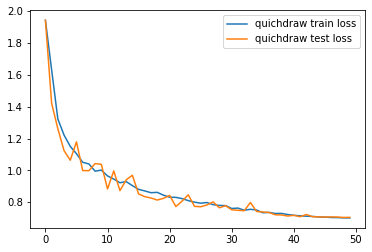

In [121]:
plt.plot(range(len(quickdraw_train_loss)), quickdraw_train_loss, label = 'quichdraw train loss')
plt.plot(range(len(quickdraw_test_loss)), quickdraw_test_loss, label = 'quichdraw test loss')
plt.legend()


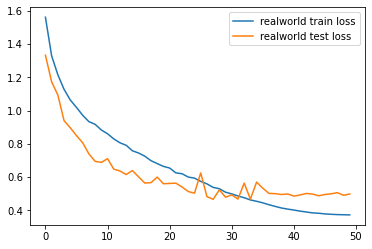

In [122]:
plt.plot(range(len(realworld_train_loss)), realworld_train_loss, label = 'realworld train loss')
plt.plot(range(len(realworld_test_loss)), realworld_test_loss, label = 'realworld test loss')
plt.legend()


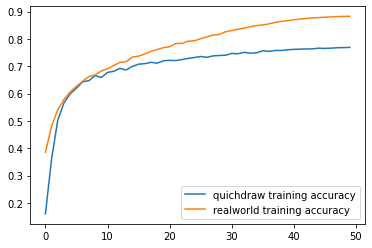

In [123]:
plt.plot(range(len(quickdraw_train_accuracy)), quickdraw_train_accuracy, label = 'quichdraw training accuracy')
plt.plot(range(len(realworld_train_accuracy)), realworld_train_accuracy, label = 'realworld training accuracy')
plt.legend()

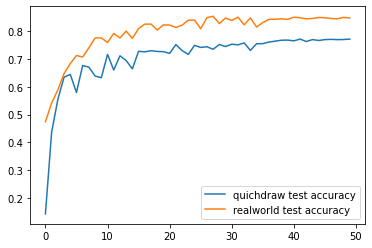

In [124]:
plt.plot(range(len(quickdraw_test_accuracy)), quickdraw_test_accuracy, label = 'quichdraw test accuracy')
plt.plot(range(len(realworld_test_accuracy)), realworld_test_accuracy, label = 'realworld test accuracy')
plt.legend()

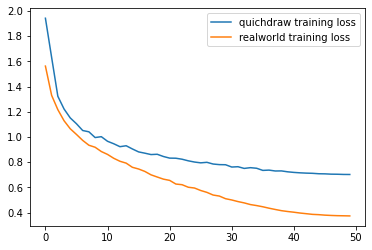

In [125]:
plt.plot(range(len(quickdraw_train_loss)), quickdraw_train_loss, label = 'quichdraw training loss')
plt.plot(range(len(realworld_train_loss)), realworld_train_loss, label = 'realworld training loss')
plt.legend()

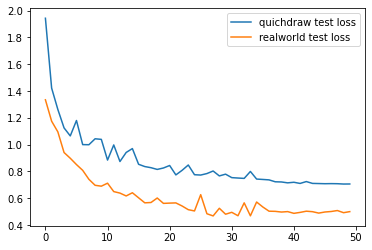

In [126]:
plt.plot(range(len(quickdraw_test_loss)), quickdraw_test_loss, label = 'quichdraw test loss')
plt.plot(range(len(realworld_test_loss)), realworld_test_loss, label = 'realworld test loss')
plt.legend()